In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()
import seaborn as sns

In [2]:
df2 = pd.read_csv('7_dwarfs_train.csv')

In [3]:
df3 = pd.read_csv('alien_saucers.csv')

In [4]:
df4 = pd.read_csv('dinosaur.csv')

In [5]:
df5 = pd.read_csv('expedition_everest.csv')

In [6]:
df6 = pd.read_csv('flight_of_passage.csv')

In [7]:
df7 = pd.read_csv('kilimanjaro_safaris.csv')

In [8]:
df8 = pd.read_csv('navi_river.csv')

In [9]:
df9 = pd.read_csv('pirates_of_caribbean.csv')

In [10]:
df10 = pd.read_csv('rock_n_rollercoaster.csv')

In [11]:
df11 = pd.read_csv('slinky_dog.csv')

In [12]:
df12 = pd.read_csv('soarin.csv')

In [13]:
df13 = pd.read_csv('spaceship_earth.csv')

In [14]:
df14 = pd.read_csv('splash_mountain.csv')

In [15]:
df15 = pd.read_csv('toy_story_mania.csv')

In [16]:
df = pd.concat([df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15])

In [17]:
df

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:51:12,NaN,45.0
1,01/01/2015,2015-01-01 08:02:13,NaN,60.0
2,01/01/2015,2015-01-01 08:05:30,54.0,NaN
3,01/01/2015,2015-01-01 08:09:12,NaN,60.0
4,01/01/2015,2015-01-01 08:16:12,NaN,60.0
...,...,...,...,...
217122,12/31/2019,2019-12-31 23:30:02,NaN,20.0
217123,12/31/2019,2019-12-31 23:37:02,NaN,15.0
217124,12/31/2019,2019-12-31 23:44:02,NaN,15.0
217125,12/31/2019,2019-12-31 23:51:02,NaN,5.0


In [18]:
df['SPOSTMIN'] = df['SPOSTMIN'].fillna((df['SPOSTMIN'].ffill()))
df = df.drop(columns = {'date'})

In [19]:
df

,datetime,SACTMIN,SPOSTMIN
0,2015-01-01 07:51:12,NaN,45.0
1,2015-01-01 08:02:13,NaN,60.0
2,2015-01-01 08:05:30,54.0,60.0
3,2015-01-01 08:09:12,NaN,60.0
4,2015-01-01 08:16:12,NaN,60.0
...,...,...,...
217122,2019-12-31 23:30:02,NaN,20.0
217123,2019-12-31 23:37:02,NaN,15.0
217124,2019-12-31 23:44:02,NaN,15.0
217125,2019-12-31 23:51:02,NaN,5.0


In [20]:
def drop_nulls(df, prop_required_column = .70, prop_required_row = .70):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [21]:
df = drop_nulls(df, prop_required_column = .70, prop_required_row = .70)

In [22]:
df = df.rename(columns = {'SPOSTMIN' : 'y', 'datetime' : 'ds', })

In [24]:
df = df[df.y > 0]
df = df[df.y < 300]

In [27]:
df.ds = pd.to_datetime(df.ds)
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [28]:
df.isnull().sum()

ds    0
y     0
dtype: int64

In [29]:
df = df.set_index('ds').sort_index()
df

,y
ds,
2015-01-01 07:45:15,5.0
2015-01-01 07:45:15,10.0
2015-01-01 07:46:22,5.0
2015-01-01 07:47:26,5.0
2015-01-01 07:47:26,5.0
...,...
2020-01-01 00:57:02,30.0
2020-01-01 00:57:02,25.0
2020-01-01 00:57:14,30.0


In [30]:
df = df.resample('D').mean().round(2)

In [31]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [32]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [34]:
y = train.y
y.head()

ds
2015-01-01    60.00
2015-01-02    58.26
2015-01-03    52.94
2015-01-04    38.44
2015-01-05    47.32
Freq: D, Name: y, dtype: float64

[Text(0, 0.5, 'Wait Time (Minutes)'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Wait Time By Month')]

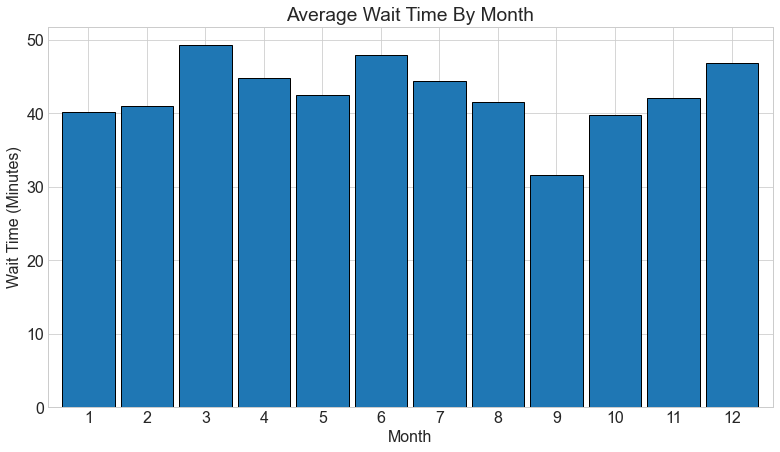

In [35]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Wait Time By Month', xlabel='Month', ylabel='Wait Time (Minutes)')

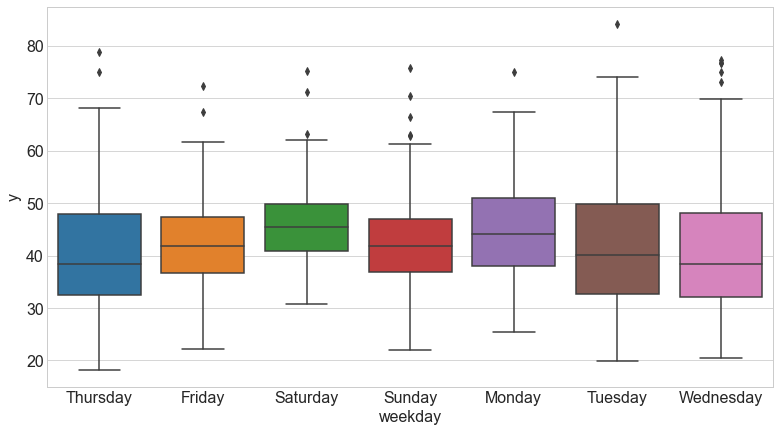

In [38]:
(
    y.reset_index()
    .assign(weekday=lambda df: df.ds.dt.day_name())
    .pipe((sns.boxplot, 'data'), y='y', x='weekday')
)

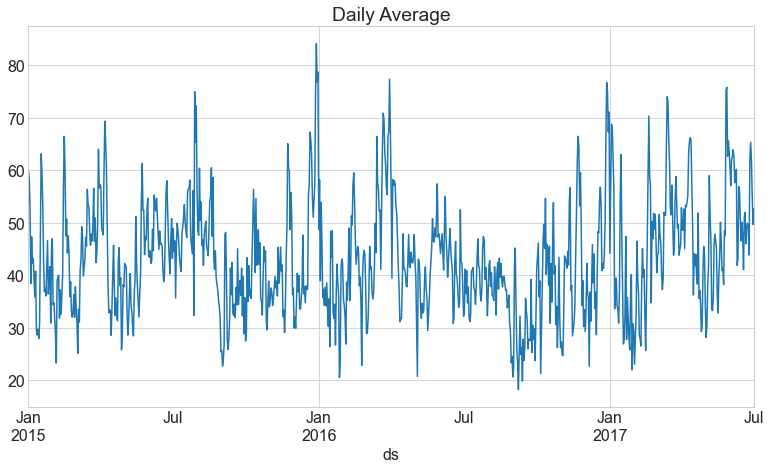

In [39]:
y.resample('D').mean().plot(title='Daily Average')

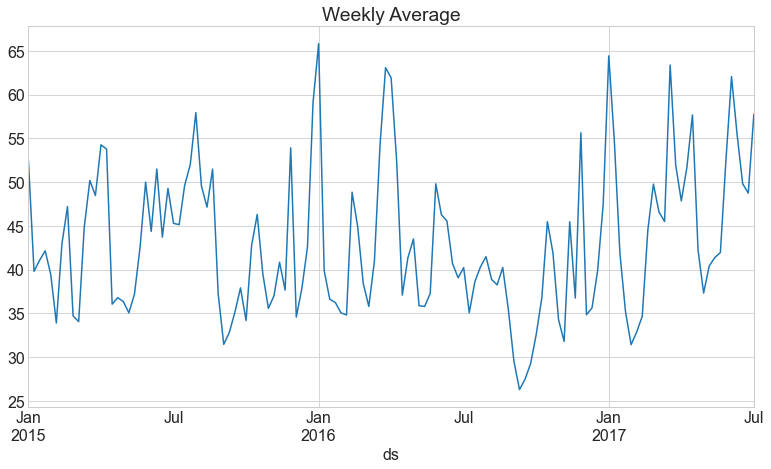

In [40]:
y.resample('W').mean().plot(title='Weekly Average')

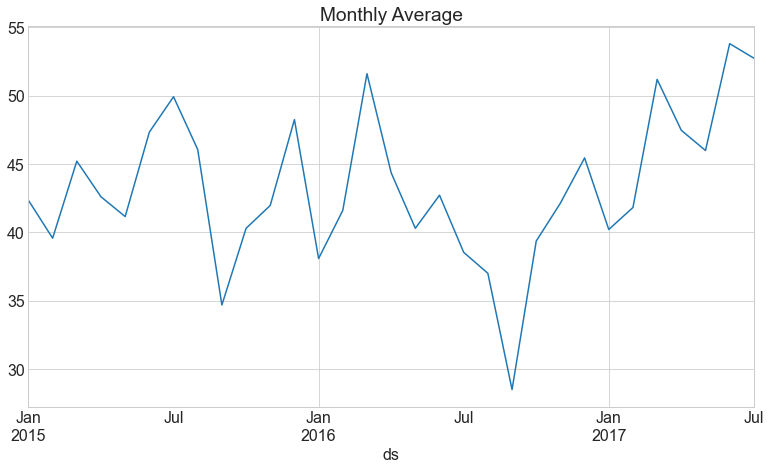

In [41]:
y.resample('M').mean().plot(title='Monthly Average')

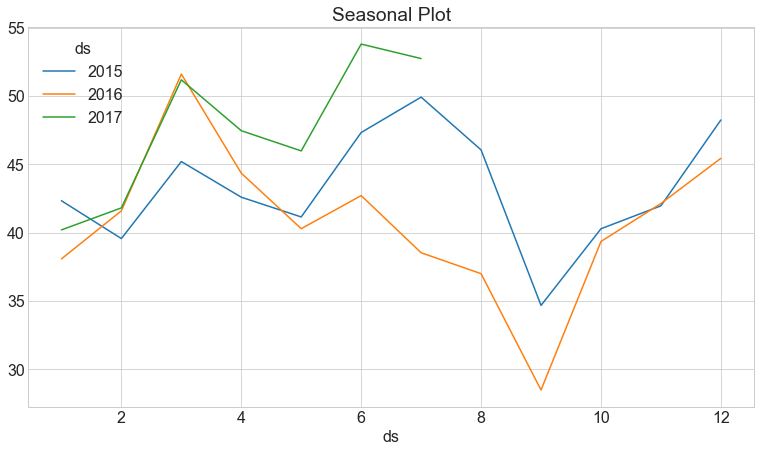

In [42]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

In [43]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [44]:
print(df.head(1) == train.head(1))

               y
ds              
2015-01-01  True


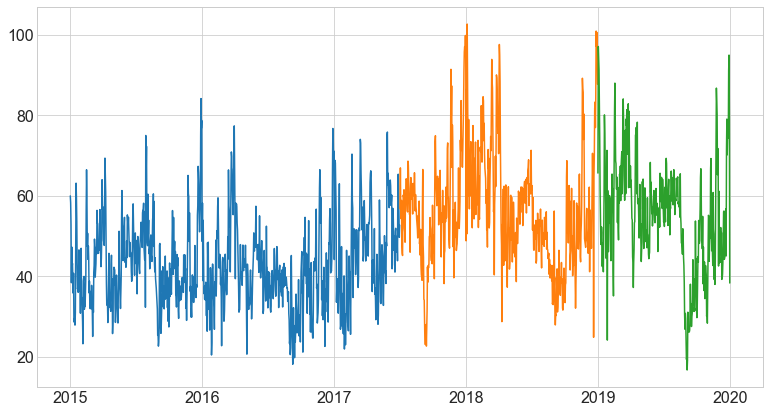

In [45]:
plt.plot(train)
plt.plot(validate)
plt.plot(test)

In [46]:
train['cap'] = 100
train['floor'] = 20

# reset index as prophet needs ds to be a column and not an index. 
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

train.head(2)

,ds,y,cap,floor
0,2015-01-01,60.00,100,20
1,2015-01-02,58.26,100,20
